In [1]:
import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

print(pd.__version__)

1.4.2


In [2]:
def get_bodies_data():    
    
    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    with open(f'{data_dir}df_od_coordinates.pkl', 'rb') as file:
        bodies_df = pickle.load(file)

    # correcting that one in manhatten
    bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude'] = bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude_p']
    bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'longitude'] = bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude_p']

    # correcting those with wrong time stamp
    bodies_df.loc[bodies_df['date created'] == '00000000', 'date created'] = np.nan

    # create ythe date time date
    bodies_df['date'] = pd.to_datetime(bodies_df['date created'], format='%Y%m%d', exact = False)

    # Create location annotation dummy
    annotation_mask = (bodies_df['longitude'].notna()) & (bodies_df['latitude'].notna())
    bodies_df['location_annot'] = annotation_mask * 1 

    return(bodies_df)

In [3]:
bodies_df = get_bodies_data()

In [4]:
# you need a dummy regarding wheter the location is infered.

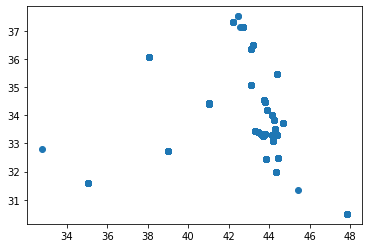

In [5]:
x = bodies_df[bodies_df['location_annot'] == 1]['longitude']
y = bodies_df[bodies_df['location_annot'] == 1]['latitude']

plt.scatter(x,y)
plt.show()

In [19]:
annotated = bodies_df.loc[bodies_df['location_annot'] == 1,'date'].values.reshape(-1, 1)
annotated_location = bodies_df.loc[bodies_df['location_annot'] == 1, ['longitude', 'latitude']]

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(annotated)

non_annotated = bodies_df.loc[bodies_df['location_annot'] == 0,'date'].values.reshape(-1, 1)
non_annotated_img_id = bodies_df.loc[bodies_df['location_annot'] == 0,'img_id'] # to merge back

distance, preds = neigh.kneighbors(non_annotated)
distance_days = pd.to_timedelta(distance.reshape(-1,)) # from nano seconds to days

non_annotated_df = pd.DataFrame({'img_id' : non_annotated_img_id, 'distance_days' : distance_days, 'pred_idx' : preds.reshape(-1,)})

annotated_location['pred_idx'] = annotated_location.reset_index().index
new_annotated_df = non_annotated_df.merge(right = annotated_location ,how='left', on= 'pred_idx')

brandnew = bodies_df.merge(right = new_annotated_df, how = 'left', on = 'img_id')

brandnew['longitude_full'] = brandnew.loc[:, 'longitude_x'].fillna(brandnew.loc[:, 'longitude_y'])
brandnew.drop(['longitude_x', 'longitude_y'], axis=1, inplace=True)

brandnew['latitude_full'] = brandnew.loc[:, 'latitude_x'].fillna(brandnew.loc[:, 'latitude_y'])
brandnew.drop(['latitude_x', 'latitude_y'], axis=1, inplace=True)

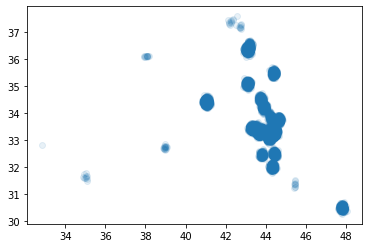

In [27]:
x = brandnew['longitude_full'] 
y = brandnew['latitude_full']

plt.scatter(x,y, alpha = 0.1)
plt.show()